# Testing Notebook

https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783
https://data.sfgov.org/profile/edit/developer_settings
https://dev.socrata.com/foundry/data.sfgov.org/wg3w-h783

# Importing Packages

In [153]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
import pandas as pd
from sodapy import Socrata
import datetime
import sys
import numpy as np

sys.path.append("..")

import src.config as config

In [155]:
import tensorflow as tf

In [411]:
from sklearn.metrics import mean_squared_error
#for modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import itertools

# Setting up the Client and Querying the Database

In [3]:
# Example authenticated client (needed for non-public datasets):
client = Socrata("data.sfgov.org",
                 config.api_key,
                 username=config.username,
                 password=config.password)

In [490]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("wg3w-h783", limit=50000, order="incident_date DESC")

# Processing the Response

In [532]:
# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])

In [533]:
df = df[~df['incident_category'].isnull()]
df = df[~df['latitude'].isnull()]
df = df[~df['police_district'].isnull()]

In [534]:
# df = df[["incident_datetime", "latitude", "longitude", "supervisor_district", 
#          "analysis_neighborhood", "police_district", "incident_category"]]

df = df[["incident_datetime", "police_district", "incident_category"]]

# Grouping and Resampling

In [535]:
avg_district_df = df.copy()
avg_district_df["Count"] = 1
avg_district_df = avg_district_df.set_index(
    avg_district_df["incident_datetime"]).drop(columns=["incident_datetime"])

In [536]:
avg_district_df = avg_district_df.groupby(['police_district', 'incident_category']).resample('1D').sum()

In [537]:
avg_district_df = avg_district_df.reset_index()

In [538]:
avg_district_df

,police_district,incident_category,incident_datetime,Count
0,Bayview,Arson,2020-08-02,1
1,Bayview,Arson,2020-08-03,0
2,Bayview,Arson,2020-08-04,0
3,Bayview,Arson,2020-08-05,0
4,Bayview,Arson,2020-08-06,0
...,...,...,...,...
53865,Tenderloin,Weapons Offense,2021-01-04,0
53866,Tenderloin,Weapons Offense,2021-01-05,0
53867,Tenderloin,Weapons Offense,2021-01-06,0
53868,Tenderloin,Weapons Offense,2021-01-07,0


# Visualizing Total Incidents

In [432]:
total_daily_incidents = avg_district_df.groupby('incident_datetime')[['Count']].sum()

In [433]:
total_daily_incidents

,Count
incident_datetime,
2020-11-21,269
2020-11-22,290
2020-11-23,292
2020-11-24,305
2020-11-25,340
2020-11-26,242
2020-11-27,383
2020-11-28,259
2020-11-29,267


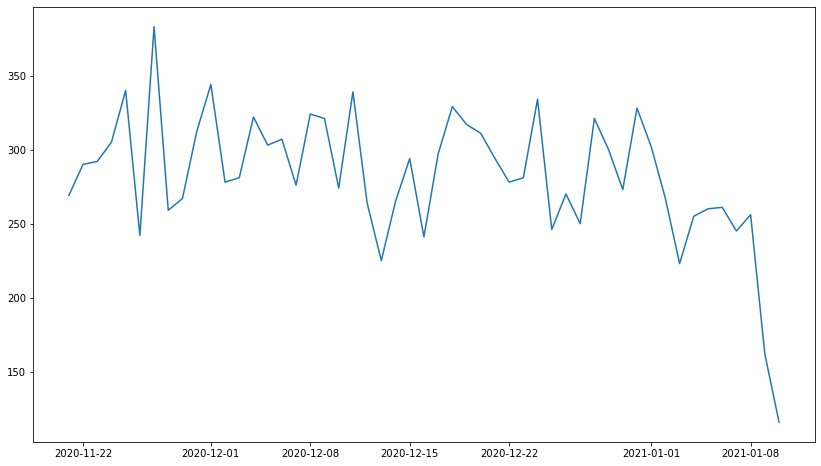

In [344]:
plt.figure(figsize=(14,8))
plt.plot(total_daily_incidents.index, total_daily_incidents.Count)

In [288]:
monthly_incidents = avg_district_df.groupby(
    pd.Grouper(key='incident_datetime', freq='w'))['Count'].sum().fillna(0) 

<AxesSubplot:xlabel='incident_datetime'>

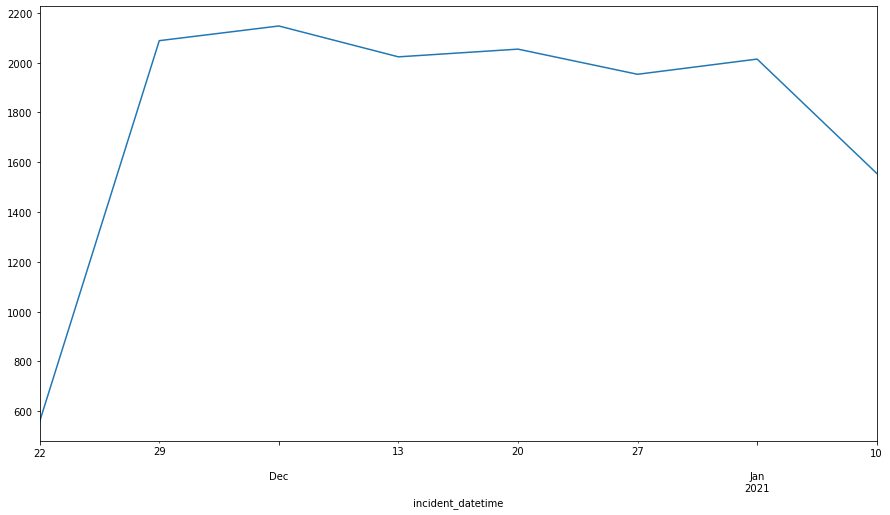

In [289]:
plt.figure(figsize=(15,8))
monthly_incidents.plot()

# Bayview Specific

In [387]:
bayview = avg_district_df[avg_district_df.police_district == "Bayview"].drop(columns=["police_district"])

In [388]:
bayview

,incident_category,incident_datetime,Count
0,Arson,2020-12-02,1
1,Arson,2020-12-03,1
2,Arson,2020-12-04,0
3,Arson,2020-12-05,0
4,Arson,2020-12-06,0
...,...,...,...
1433,Weapons Offense,2021-01-06,0
1434,Weapons Offense,2021-01-07,1
1435,Weapons Offense,2021-01-08,1
1436,Weapons Offense,2021-01-09,1


In [389]:
bayview = pd.concat([bayview, pd.get_dummies(
    bayview["incident_category"])], axis=1).drop(columns=["incident_category"])

In [390]:
bayview

,incident_datetime,Count,Arson,Assault,Burglary,Case Closure,Courtesy Report,Disorderly Conduct,Drug Offense,Drug Violation,...,Sex Offense,Stolen Property,Suspicious Occ,Traffic Collision,Traffic Violation Arrest,Vandalism,Vehicle Impounded,Warrant,Weapons Carrying Etc,Weapons Offense
0,2020-12-02,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-12-03,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-12-04,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-12-05,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-12-06,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,2021-01-06,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1434,2021-01-07,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1435,2021-01-08,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1436,2021-01-09,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [377]:
bayview[bayview.Count == 2]

,incident_datetime,Count,Arson,Assault,Burglary,Case Closure,Courtesy Report,Disorderly Conduct,Drug Offense,Drug Violation,...,Sex Offense,Stolen Property,Suspicious Occ,Traffic Collision,Traffic Violation Arrest,Vandalism,Vehicle Impounded,Warrant,Weapons Carrying Etc,Weapons Offense
5,2020-12-07,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,2020-11-22,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,2020-11-23,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,2020-12-23,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,2020-12-26,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,2021-01-10,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1413,2020-12-17,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1416,2020-12-20,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1420,2020-12-24,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<BarContainer object of 1438 artists>

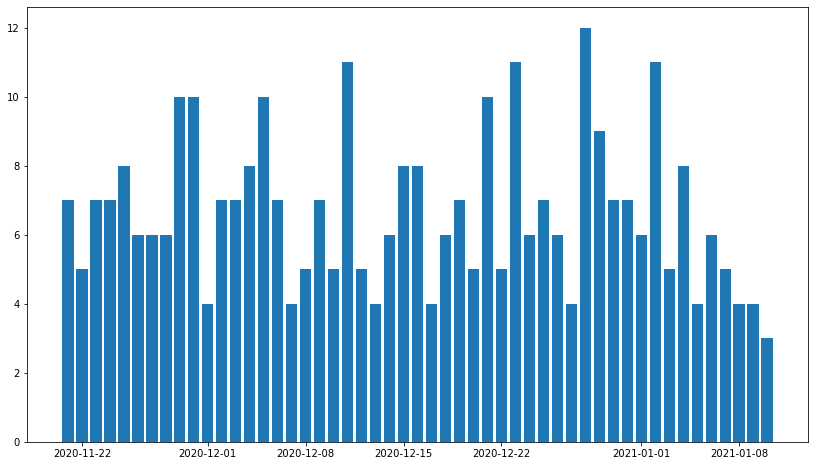

In [347]:
plt.figure(figsize=(14,8))
plt.bar(bayview.incident_datetime, bayview.Count)

# Bayview- Specific Model

In [348]:
bayview_larceny = bayview[bayview.incident_category == "Larceny Theft"]

In [276]:
date_time = pd.to_datetime(bayview_larceny.pop('incident_datetime'), format='%d.%m.%Y %H:%M:%S')

In [277]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [138]:
df = pd.concat([df, pd.get_dummies(df["police_district"])], axis=1).drop(columns=["police_district", "Count"])

In [140]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

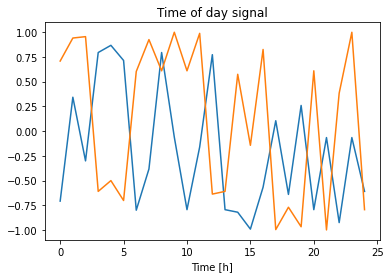

In [141]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [142]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [143]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [148]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [149]:
df

,incident_category,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,Day sin,Day cos,Year sin,Year cos
1,Other Miscellaneous,1,0,0,0,0,0,0,0,0,0,0,-0.707107,0.707107,0.179775,0.983708
2,Larceny Theft,0,1,0,0,0,0,0,0,0,0,0,0.342020,0.939693,0.182830,0.983145
3,Assault,0,0,0,0,1,0,0,0,0,0,0,-0.300706,0.953717,0.181068,0.983471
4,Assault,0,0,0,0,0,0,0,0,0,0,1,0.793353,-0.608761,0.170955,0.985279
5,Recovered Vehicle,0,0,0,1,0,0,0,0,0,0,0,0.866025,-0.500000,0.170601,0.985340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,Non-Criminal,0,1,0,0,0,0,0,0,0,0,0,-0.173648,0.984808,-0.627009,0.779012
14995,Suspicious Occ,0,0,0,0,0,0,0,0,1,0,0,-0.866025,-0.500000,-0.631095,0.775705
14996,Larceny Theft,0,0,0,0,0,0,1,0,0,0,0,-0.321439,0.946930,-0.627335,0.778750
14998,Other Miscellaneous,0,0,1,0,0,0,0,0,0,0,0,-0.669131,0.743145,-0.628200,0.778052


In [151]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['incident_category'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['incident_category']

In [152]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['incident_category'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['incident_category']

# Old

In [136]:
date_time = pd.to_datetime(df.pop('incident_datetime'), format='%d.%m.%Y %H:%M:%S')

In [137]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [138]:
df = pd.concat([df, pd.get_dummies(df["police_district"])], axis=1).drop(columns=["police_district", "Count"])

In [140]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

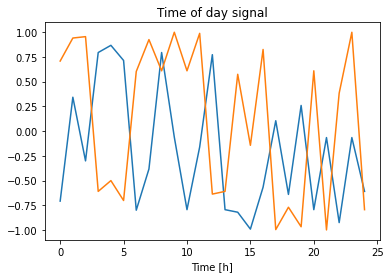

In [141]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [142]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [143]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [148]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [149]:
df

,incident_category,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,Day sin,Day cos,Year sin,Year cos
1,Other Miscellaneous,1,0,0,0,0,0,0,0,0,0,0,-0.707107,0.707107,0.179775,0.983708
2,Larceny Theft,0,1,0,0,0,0,0,0,0,0,0,0.342020,0.939693,0.182830,0.983145
3,Assault,0,0,0,0,1,0,0,0,0,0,0,-0.300706,0.953717,0.181068,0.983471
4,Assault,0,0,0,0,0,0,0,0,0,0,1,0.793353,-0.608761,0.170955,0.985279
5,Recovered Vehicle,0,0,0,1,0,0,0,0,0,0,0,0.866025,-0.500000,0.170601,0.985340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,Non-Criminal,0,1,0,0,0,0,0,0,0,0,0,-0.173648,0.984808,-0.627009,0.779012
14995,Suspicious Occ,0,0,0,0,0,0,0,0,1,0,0,-0.866025,-0.500000,-0.631095,0.775705
14996,Larceny Theft,0,0,0,0,0,0,1,0,0,0,0,-0.321439,0.946930,-0.627335,0.778750
14998,Other Miscellaneous,0,0,1,0,0,0,0,0,0,0,0,-0.669131,0.743145,-0.628200,0.778052


In [151]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['incident_category'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['incident_category']

In [152]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['incident_category'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['incident_category']